# CNN Classification of Mel Spectrograms

Tried and follow
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

In [1]:
# For Colab only
# 4/1AY0e-g6CTocvBK45PWlJu2ycBuOMTgu36b-VZgpnCXitW_Vy3ckpGGBzur8
# from google.colab import drive
# drive.mount('content/')
# /content/drive/MyDrive/bird-songs

## Training a model

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import os.path

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn import init
# from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, functional
from torch.optim import Adam

In [2]:
# Check whether google drive mounted
path = '/content/content/MyDrive/bird-songs'
if os.path.isdir(path) == True:
    run_on_colab = True
else:
    run_on_colab = False


if run_on_colab ==True:
    features = pd.read_csv('/content/content/MyDrive/bird-songs/features.csv', header=None, encoding='latin')
else:
    features = pd.read_csv('features_filtered.csv', encoding='latin')
# features.columns= ['id', 'gen', 'sp', 'ssp', 'en', 'cnt', 'loc','type', 'q', 'length', 'bird-seen']
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download
4,539275,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,Upper St. Clair Township (near Upper Saint Cl...,"call, song",no score,1:12,yes,//www.xeno-canto.org/539275/download


In [3]:
# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en']]
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
dataset['label'] = dataset.apply(lambda row: labels[row.en], axis=1)
dataset.drop('en', axis=1, inplace=True)

In [4]:
def load_images(dataset):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        if run_on_colab == True:
            image_path = '/content/content/MyDrive/bird-songs/images/mel_spectrograms_8sec/' + str(img_name) + '.jpg' 
        else:
            image_path = 'images/mel_spectrograms_8sec/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path, as_gray=True)
         # normalizing the pixel values
        img = 2 * img - 1
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        img_df.append(img)
    
    # converting the list to numpy array
    return np.array(img_df)

In [5]:
X, y = load_images(dataset), dataset['label'].values
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:03<00:00, 645.05it/s]


((2516, 128, 345), (2516,))

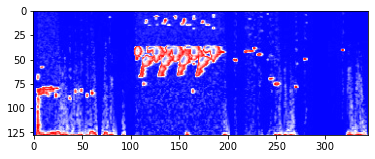

In [6]:
img = X[0]
plt.imshow(img, cmap='bwr')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print('')
print(X_test.shape)

(2012, 128, 345)

(504, 128, 345)


## CNN

If you have compatible GPU technology on your computer, you can run the CNN on it instead of CPU. 
If you are using anaconda, either create a new environment or uninstall pytorch in your current environment (if already installed) then install PyTorch with cuda:

`conda install pytorch torchvision cudatoolkit=10.2 -c pytorch`

Running this CNN on CPU takes about 17 minutes on a Dell XPS 15 9500 with 1TB SSD and 32GB RAM (2x16GB) with Windows 10. Switching to using the NVIDIA GeForce GTX 1650 it takes less than 5minutes. 

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
train_data = []
for i in range(len(X_train)):
    train_data.append([np.expand_dims(X_train[i], axis=0), y_train[i]]) #Conv2d layers expect input with the shape (n_samples, channels, height, width)

test_data = []
for i in range(len(X_test)):
    test_data.append([np.expand_dims(X_test[i], axis=0), y_test[i]])

In [17]:
train_data[0][0].shape

(1, 128, 345)

In [18]:
batch_size=50
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [19]:
dataiter = iter(train_dl)
images, labels = dataiter.next()

print (images[0].shape)

torch.Size([1, 128, 345])


In [20]:
# Test image size
# simple_model = nn.Sequential(
#     nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
#     nn.ReLU(),
#     nn.MaxPool2d(2),

#     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),

#     nn.Flatten(), 
#     nn.Linear(256*3*7, 1024),
#     nn.ReLU(),
#     nn.Linear(1024, 5)
# )
# for images, labels in train_dl:
#     print('images.shape:', images.shape)
#     out = simple_model(images)
#     print('out.shape:', out.shape)
#     break

In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.GroupNorm(2, 32)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.pool1 = nn.MaxPool2d(2)
        conv_layers += [self.conv1, self.relu1, self.bn1, self.pool1]

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.GroupNorm(4, 64)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.pool2 = nn.MaxPool2d(2)
        conv_layers += [self.conv2, self.relu2, self.bn2, self.pool2]
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.pool3 = nn.MaxPool2d(2)
        conv_layers += [self.conv3, self.relu3, self.pool3]

        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.pool4 = nn.MaxPool2d(2)
        conv_layers += [self.conv4, self.relu4, self.pool4]
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256*2*5, 50)
        self.relufc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(50, 10)
        self.relufc2 = nn.ReLU()
        self.linear3 = nn.Linear(10, 6)
        conv_layers += [self.flatten, self.linear1, self.relufc1, self.dropout,
                        self.linear2, self.relufc2, self.linear3]
        
        self.network = nn.Sequential(*conv_layers)
        print(conv_layers)
    def forward(self, x):
        return self.network(x)



In [23]:
model = Net()
print(model)

[Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)), ReLU(), GroupNorm(2, 32, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)), ReLU(), GroupNorm(4, 64, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Flatten(start_dim=1, end_dim=-1), Linear(in_features=2560, out_features=50, bias=True), ReLU(), Dropout(p=0.5, inplace=False), Linear(in_features=50, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=6, bias=True)]
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), paddin

In [376]:
# Test the model on the first batch from the training dataloader
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([50, 1, 128, 345])
out.shape: torch.Size([50, 6])
out[0]: tensor([ 0.3137,  0.2302,  0.0529, -0.2673,  0.2048,  0.0260],
       grad_fn=<SelectBackward>)


In [377]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [378]:
device = get_default_device()
device

device(type='cuda')

In [379]:
# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [380]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [381]:
model = to_device(Net(), device)

[Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)), ReLU(), GroupNorm(2, 32, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)), ReLU(), GroupNorm(4, 64, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Flatten(start_dim=1, end_dim=-1), Linear(in_features=2560, out_features=50, bias=True), ReLU(), Dropout(p=0.5, inplace=False), Linear(in_features=50, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=6, bias=True)]


In [382]:
# evaluate(model, test_dl)

In [383]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00005

In [384]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 1.8086, val_loss: 1.7847, val_acc: 0.2045
Epoch [1], train_loss: 1.7854, val_loss: 1.7883, val_acc: 0.2209
Epoch [2], train_loss: 1.7841, val_loss: 1.7540, val_acc: 0.2600
Epoch [3], train_loss: 1.7680, val_loss: 1.7575, val_acc: 0.2264
Epoch [4], train_loss: 1.7509, val_loss: 1.7208, val_acc: 0.2991
Epoch [5], train_loss: 1.7247, val_loss: 1.6778, val_acc: 0.3109
Epoch [6], train_loss: 1.6925, val_loss: 1.6340, val_acc: 0.3591
Epoch [7], train_loss: 1.6535, val_loss: 1.6310, val_acc: 0.3264
Epoch [8], train_loss: 1.6059, val_loss: 1.5381, val_acc: 0.4018
Epoch [9], train_loss: 1.5865, val_loss: 1.5181, val_acc: 0.4018
Epoch [10], train_loss: 1.5021, val_loss: 1.4701, val_acc: 0.4209
Epoch [11], train_loss: 1.4458, val_loss: 1.3925, val_acc: 0.4918
Epoch [12], train_loss: 1.4072, val_loss: 1.3805, val_acc: 0.4536
Epoch [13], train_loss: 1.3516, val_loss: 1.3593, val_acc: 0.4909
Epoch [14], train_loss: 1.3112, val_loss: 1.2472, val_acc: 0.5400
Epoch [15], train_lo

In [385]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

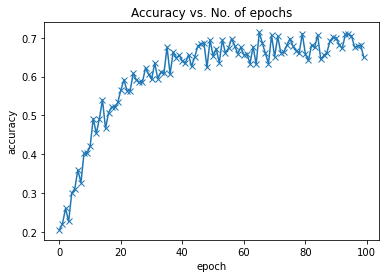

In [386]:
plot_accuracies(history)

Runs:
- Run1: dropout = 0.25 + 3 linear layers => accuracy = 0.6301
- Run 2: dropout = 0.25 + 2 linear layers => accuracy = 0.6127
- Run 3: dropout = 0.5 + 3 linear layers => accuracy = 0.6373
- Run 4: dropout = 0.5 + 2 linear layers => accuracy = 0.6227
- Run 5: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer => accuracy = 0.6491 (plus went up to 0.70!)
- Run 6: dropout = 0.5 + 2 linear layers + dropping the last convolutional layer => accuracy = 0.6445 (not up to 0.70)
- Run 7: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + last kernel at 2 with 0 padding => accuracy = 0.6073
- Run 8: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + BatchNorm2d momentum set to None (for cumulative moving average) => accuracy = 0.5464
- Run 9: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + InstanceNorm2d instead of BatchNorm2 as the normalization layer => accuracy = 0.6418
- Run 10: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(8, n_channels) instead of BatchNorm2 as the normalization layer => accuracy = 0.6455
- Run 11: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(8, 32) then (16, 64)  instead of BatchNorm2 as the normalization layer => accuracy = 0.6373
- Run 12: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(4, 32) then (8, 64)  instead of BatchNorm2 as the normalization layer => accuracy = 0.6582
- Run 13: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(4, 32) then (4, 64)  instead of BatchNorm2 as the normalization layer => accuracy = 0.6591
- Run 14: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(2, 32) then (4, 64)  instead of BatchNorm2 as the normalization layer => accuracy = 0.6645
- Run 15: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(2, 32) then (2, 64)  instead of BatchNorm2 as the normalization layer => accuracy = 0.6336
- Run 16: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(2, 32) then (4, 64)  instead of BatchNorm2 as the normalization layer + PoissonNLLoss instead of CrossEntropyLoss as loss function => accuracy = 0.6655 (actually loss function not implemented so same as run 14)
- Run 17: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(2, 32) then (4, 64)  instead of BatchNorm2 as the normalization layer + AdamW instead of Adam as optimizer function => accuracy = 0.6418
- Run 18: dropout = 0.5 + 3 linear layers + dropping the last convolutional layer + GroupNorm(2, 32) then (4, 64)  instead of BatchNorm2 as the normalization layer + Adamax instead of Adam as optimizer function => accuracy = 0.5409

note: AdaDelta gave very low score

Best run: Run 16